## Weather Prediction using InfluxDB

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from influx import query_batch, convert

from tensorflow.python.framework import dtypes
from tensorflow.contrib import learn as tflearn
from tensorflow.contrib import layers as tflayers

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Number of hours in the past to predict the next hour's weather

In [3]:
HOURS = 48

14920 is the LSE airport... nearest airport to me!

In [4]:
WBAN = 14920

In [5]:
def model(X, y):
    basics = [tf.nn.rnn_cell.BasicLSTMCell(5, state_is_tuple=True)]
    stacked_lstm = tf.nn.rnn_cell.MultiRNNCell(basics, state_is_tuple=True)
    x_ = tf.unpack(X, axis=1, num=HOURS)
    output, layers = tf.nn.rnn(stacked_lstm, x_, dtype=dtypes.float32)
    output = tflayers.stack(output[-1], tflayers.fully_connected, [10, 10])
    prediction, loss = tflearn.models.linear_regression(output, y)
    train_op = tf.contrib.layers.optimize_loss(
                loss, tf.contrib.framework.get_global_step(), optimizer='Adagrad',
                learning_rate=0.1)
    return prediction, loss, train_op

In [6]:
def influx(db, query, column):
    # HOURS + 1 is used to grab HOURS and the hour to predict
    for res in query_batch(query, limit=HOURS + 1, offset=0, db=db):
        for s in convert(res.raw):
            v = np.array(s.feature_lists.feature_list[column].feature[0].float_list.value, dtype=np.float32)
            data = np.zeros((HOURS,), dtype=np.float32)
            data[:v.shape[0]-1] = v[:v.shape[0]-1]
            data = np.array(data).reshape([48, -1]) 
            target = np.array(v[-1])
            yield data, target

In [7]:
with tf.Session() as sess:
    db = "tensorflowdb"
    query = "select wet_bulb_temp from qclcd where wban = '{0}' and time > now() - 365d group by wban".format(WBAN)
    column = "column/wet_bulb_temp"
    regressor = tflearn.SKCompat(tflearn.Estimator(model_fn=model))

    X = []
    y = []
    for x, target in influx(db, query, column):
        X.append(x)
        y.append(target)

    X = np.array(X)
    y = np.array(y)
    print(X.shape)
    print(y.shape)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
    
    validation_monitor = tflearn.monitors.ValidationMonitor(X_val, y_val, every_n_steps=100, early_stopping_rounds=100)
    regressor.fit(X_train, y_train, monitors=[validation_monitor], batch_size=20, steps=1000)
    

    predicted = regressor.predict(X_test)
    #not used in this example but used for seeing deviations
    rmse = np.sqrt(((predicted - y_test) ** 2).mean(axis=0))

    score = mean_squared_error(predicted, y_test)
    print ("MSE: %f" % score)

(214, 48, 1)
(214,)
MSE: 5.163718


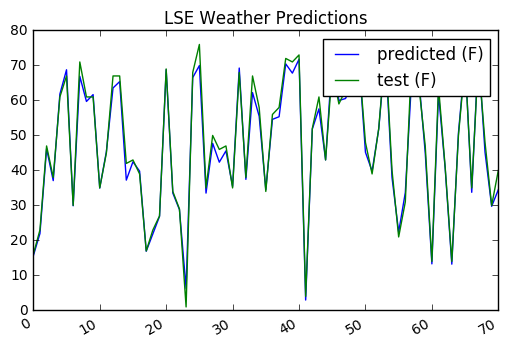

In [8]:
fig, ax = plt.subplots(1)
fig.autofmt_xdate()

plot_predicted, = ax.plot(predicted.flatten(), label='predicted (F)')
plot_test, = ax.plot(y_test.flatten(), label='test (F)')

plt.title('LSE Weather Predictions')
plt.legend(handles=[plot_predicted, plot_test])
plt.show()